# GPU run on 3rd Grid Search CV run on Google Colab

***IMPORTANT:***

**This is not the main XGBoost notebook, and is incomplete.  Please see the file `erwait_model_xgboost.ipynb` for the complete notebook.**


- This notebook only documents the cells around the execution of the 3rd GridSearchCV attempt, run on a GPU on Google Colab.  The associated notebook referenced above, rebuilds the XGBoostClassifier based on the `best_params_` discovered in this and the 2nd GridSearchCV attempt.

In [1]:
# For portions of this notebook that ran on Google Colab for the GPU - Uncomment to use on Colab
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/src')

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from modules.utility import Utility
from IPython.display import display
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import pickle

In [3]:
# # Uncomment code as required to force reload utility.py
# # Was only required during development of this notebook

# from importlib import reload
# import modules.utility
# reload(modules.utility)
# from modules.utility import Utility

# Setup

Remove display limits for column and row lengths, for easier viewing of dataframes

In [4]:
# Set no limits for number of columns and rows to display
# Utility.reset_display_max_cols_rows() to reset
Utility.setup_display_max_cols_rows()

Load the cleaned data

In [5]:
# Load the final, melted, cleaned dataset
df = Utility.get_clean_waittimes_dataframe()
df.head()

,datetime,hospital,waittime,year,dayofweek,numdayofweek,weekofyear,hour,dayperiod,id,services,city,cityarea,citypop,citytype,hosplat,hosplong
0,2022-09-24 18:22:00,Alberta Children's Hospital,201.0,2022,Saturday,5,38,18,evening,ach,emergency,Calgary,826,1306784,urban,51.074759,-114.146833
1,2022-09-24 18:22:00,Chinook Regional Hospital,69.0,2022,Saturday,5,38,18,evening,crh,emergency,Lethbridge,122,98406,peri,49.685221,-112.816209
2,2022-09-24 18:22:00,Devon General Hospital,132.0,2022,Saturday,5,38,18,evening,dgh,emergency,Devon,14,6545,rural,53.352265,-113.728288
3,2022-09-24 18:22:00,Foothills Medical Centre,188.0,2022,Saturday,5,38,18,evening,fmc,emergency,Calgary,826,1306784,urban,51.064657,-114.130926
4,2022-09-24 18:22:00,Fort Sask Community Hospital,295.0,2022,Saturday,5,38,18,evening,fsch,emergency,Fort Saskatchewan,48,27088,rural,53.693175,-113.213436


In [6]:
# Original df shape
df.shape

(201151, 17)

Remove 'Urgent Care' facilities so we are only modelling on ERs

In [7]:
# Filter the dataframe to be only Emergency services
ER_SERVICES_MASK = Utility.MASK_EMERGENCY_SERVICES(df)
df = df[ER_SERVICES_MASK]

In [8]:
# df shape after dropping 'urgentcare' services
df.shape

(181926, 17)

# Prepare data for modeling

Try a logistic regression classification learning model where y = binary outcome of long wait, where I have **defined long wait as "greater than 400 minutes (6.67 hours)"**.

This '400 minute' choice was based on the following:
* Looking at the descriptive statistics for the entire dataset or ER hospitals
* Calculating the upper bound for outliers (`Q3 + IQR*1.5`) cut off for ER hospitals (500 minutes)
* The following national guidelines, with images shown in readme.md:
    - Canadian ED Triage & Acuity Scale, 1998: https://ctas-phctas.ca/wp-content/uploads/2018/05/ctased16_98.pdf
        - Specifying lowest triage level (Level V) should have time to physician <= 2 hours
    - CAEP (Canadian Associate of Emergency Physicians) Position Statement, 2013: "Emergency department overcrowding and access block":  https://caep.ca/wp-content/uploads/2016/03/cjem_2013_overcrowding_and_access_block.pdf
        - Specifying recommendation for median 1 hour to PIA and 3 hours at 90% percentile
    - Alberta Health Performance Measure Definition for TPIA (Time to Physician Initial Assessment) (Feb 2015): https://open.alberta.ca/dataset/c7e3fc16-7aea-455c-96a1-20811a640b1a/resource/e2f49c22-3390-48a3-ac74-278a932aa668/download/pmd-ed-time-physician-initial-assessment.pdf
        - Specifying national sides averaging 3.2 hours, Alberta sites averaging 3.1 hours (in 2012-13)
    - "Physician Initial Assessment Times Based on CTAS Scores: Are We Meeting the Recommendations?": https://www.longwoods.com/content/26333/healthcare-quarterly/physician-initial-assessment-times-based-on-ctas-scores-are-we-meeting-the-recommendations-
        - Specifying "overall compliance with recommended PIA times was low" in 4 community EDs around Hamilton, Ontario from 2016-2017.


Feature Engineer:
* longwait: 0 or 1

Drop:
* datetime
* hospital (we will use 'id' instead)
* waittime (we are using our binary value of 'longwait' instead, because this is a classification problem)
* year
* numdayofweek (we will use 'dayofweek' instead)
* services (they are all 'emergency' based on our earlier filter)
* cityarea
* citypop
* hosplat
* hosplong

We will also do additional feature engineering to simplify features:
* collapse citytype 'peri' into 'rural', and keep this feature

**NOTE: I have defined constants and utility functions in the `Utility` class in `modules.utility` (modules/utility.py file) to ensure consistency in shaping the dataframe that is ultimately used for modelling, in each classifier I build.**

In [9]:
# Create new dataframe called df_model
df_model = df.copy()

# Collapse citytype 'peri' into 'rural'.  This is a valid assumption as demonstrated by plots in the erwait_eda_hypothesis_testing.ipynb notebook.
Utility.collapse_periurban_to_rural(df_model)

# Engineer the new feature 'longwait'
Utility.add_longwait_feature(df_model)

# Drop unwanted columns, which are defined as Utility.LOGIT_DROP_COLS, for consistent use in every notebook for every classification model.
Utility.drop_unwanted_columns(df_model, Utility.LOGIT_DROP_COLS)

Confirm how the dataframe looks after:
* Collapsing peri to rural
* Adding the 'longwait' feature (this will be our target variable)
* Dropping unwanted columns/features

In [10]:
Utility.display_df_general_info(df_model)
# display(df_model.head())
# print(f"\nShape of df_model: {df_model.shape}")
# print(f"\nColumns of df_model: {df_model.columns}")
# print(f"\ndtypes of df_model: {df_model.dtypes}")

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Saturday,38,18,evening,ach,Calgary,urban,0
1,Saturday,38,18,evening,crh,Lethbridge,rural,0
2,Saturday,38,18,evening,dgh,Devon,rural,0
3,Saturday,38,18,evening,fmc,Calgary,urban,0
4,Saturday,38,18,evening,fsch,Fort Saskatchewan,rural,0



Shape of dataframe:
(181926, 8)

Columns of dataframe:
Index(['dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city',
       'citytype', 'longwait'],
      dtype='object')

dtypes of dataframe:
dayofweek     object
weekofyear     int64
hour           int64
dayperiod     object
id            object
city          object
citytype      object
longwait       int64
dtype: object


Sort the dataframe a consistent and particular way (as defined in Utility class) prior to one-hot encoding, so that the one-hot encoding is consistent across all notebooks for all classification models.

In [11]:
df_model = Utility.sort_df_before_encoding_or_modeling(df_model)

Check what it looks like after sorting


In [12]:
df_model.head()

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Friday,1,0,night,ach,Calgary,urban,0
1,Friday,1,0,night,crh,Lethbridge,rural,0
2,Friday,1,0,night,dgh,Devon,rural,0
3,Friday,1,0,night,fmc,Calgary,urban,1
4,Friday,1,0,night,fsch,Fort Saskatchewan,rural,0


# BRANCH FOR DIFFERENT MODELS AT THIS POINT.
AT THIS POINT IN THE NOTEBOOK, THE FOUNDATIONAL DATA SETUP THAT IS SHARED BY THE MODELS FOLLOWING, HAS BEEN SETUP.

BRANCH HERE

Findings: **labelpartialsmote** is the best treatment overall with the best overall scores.

It is the highest for accuracy, precision, macro F1, weighted F1.  It is 2nd place on Recall and regular F1 and roc_auc.

There appears to be a bit of a tradeoff between precision and recall, in that for a precision gain, we lose some in recall.

This "labelpartialsmote" data preparation is the most promising if we wanted to do a GridSearchCV to attempt to hyperparameter tune and try to squeeze better performance out of the XGBoost model type.

# Can We Do Better on XGBoost Model?

Can we run this dataset in a GridSearchCV, using an exhaustive search against the various hyperparameters for the XGBoost, and change the scoring to be `f1`, that may help with the overfitting?

Hyperparameters to tune, and sample options (for Run #1):
```
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}
```

From: https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390 (https://archive.is/LKqQ7)

### Ensure everything is set up from base, for 'labelpartialsmote' situation!

We will build a model using data set up same as "LabelPartial", but with SMOTE and RandomUnderSampler (sampling_strategy=0.1 and 0.5, respectively, as those were used on basic LogisticRegression) and `scale_pos_weight` set appropriately after the splits.

In [110]:
# Make a copy of df_model first
df_model_labelpartial = df_model.copy()

# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model_labelpartial = Utility.one_hot_encode_categorical_columns(df_model_labelpartial, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model_labelpartial)

# Label Encode 'hour' and 'weekofyear'
label_encoder = LabelEncoder()
for column in ['hour', 'weekofyear']:
    df_model_labelpartial[column] = label_encoder.fit_transform(df_model_labelpartial[column])

## Set X and y dataframes for "labelpartialsmote" model

In [111]:
X_model = (df_model_labelpartial.drop(['longwait'], axis=1))
y_model = (df_model_labelpartial['longwait'])

## Train-Test Split for Model: "labelpartialsmote"

In [112]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

### Need to Oversample the minority class and undersample entire dataset
Code idea/credit: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification

(I made a couple tweaks!)

In [113]:
# Use the same X_train and y_train from the "baseline" code in LogisticRegression notebook, with sampling_strategy 0.1 for SMOTE and 0.5 for RandomUnderSampler
over = SMOTE(sampling_strategy=0.10, random_state=Utility.RANDOM_STATE_CONST)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=Utility.RANDOM_STATE_CONST)  # Best params from Logit Grid Search
steps = [('smote', over), ('under', under)]
imbpipeline_sm_under = IMBPipeline(steps=steps)
X_train, y_train = imbpipeline_sm_under.fit_resample(X_train, y_train)

In [114]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape: {X_model.shape}")
print(f"y_model.shape: {y_model.shape}")

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape: (181926, 40)
y_model.shape: (181926,)
X_train.shape: (40740, 40)
y_train.shape: (40740,)
X_test.shape: (36386, 40)
y_test.shape: (36386,)


Check class distributions in y_train and y_test after the train_test_split.

For this class imbalance, we will experiment in the GridSearch with different `scale_pos_weight` parameters on the XGBClassifier, including the default which is `1` and also the `scale_pos_weight` set in the below cells, for the recommended majority/minority class ratio.

In [115]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 27160, 1: 13580}), 0: 66.66666666666666, 1: 33.33333333333333
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [116]:
# Set new scale_pos_weight based on above numbers
# 0: 66.66666666666666, 1: 33.33333333333333

# As suggested by XGBoost documentation (https://xgboost.readthedocs.io/en/stable/parameter.html),
# set this to sum(majority_class)/sum(minority_class)
scale_pos_weight = float(66.67/33.33)
scale_pos_weight

2.0003000300030003

## Call GridSearchCV

Note:  All the below code exeecutions were in the context of the 3rd Run of Hyperparameter Tuning via GridSearchCV on Google Colab.

For more contextual details, see the notebook entitled 'erwait_model_xgboost.ipynb'.

Define GridSearchCV with:
* param_grid with hyperparameters as defined in cells below
* XGBClassifier instantiated with Utility.RANDOM_STATE_CONST, tree_method='hist', device='cuda', predictor='gpu_predictor' <-- This was for GPU usage on Google colab
* `scoring = 'f1_macro'`
* `n_jobs = -1`
* `verbose=2`
* `cv=5`

Useful information about each of the hyperparameters being tuned for XGBoost
(Credit: Lighthouse Labs' "LarryBot" chatbot):

* max_depth: This controls the depth of the tree. Greater depth can increase the model's ability to capture more complex patterns but can also lead to overfitting.
* learning_rate: This is a shrinkage parameter that helps in preventing overfitting by making the boosting process more conservative.
* gamma: This is the minimum loss reduction required to make a further partition on a leaf node of the tree, serving as a complexity control.
* reg_lambda: This is the L2 regularization term on weights, which can discourage large weights and thus control overfitting.
* scale_pos_weight: Used to balance the classes in an imbalanced dataset.
* subsample: The fraction of samples to be used for fitting the individual base learners. Setting it to 0.8 means that each tree will be trained on 80% of the data.
* colsample_bytree: The fraction of features to be used for each tree. A lower value can provide more diversity in the trees.

### 3 different GridSearchCV with 3 differents sets of hyperparameters were run using Google Colab's GPU.

The 1st set of hyperparameters resulted in best_estimator_ that performed much worse than all of the base models prior.
The 2nd set of executions resulted in the best performance over all
The 3rd set of executions resulted in better performance than the base models, but worse than the 2nd set of executions.

The `best_params_` for 2nd and 3rd executions will be used to reconstruct an XGBoostClassifier model for each grid_search execution #2 and #3 in this workbook in the local machine, to do scores comparisons with.

#### These were the values that were achieved on Google Colab with 2nd execution params:

2nd run params:
```
param_grid = {
    "max_depth": [6, 7, 9],                    # Control model complexity (overfitting)
    "learning_rate": [0.05, 0.1, 0.2],         # Affects the rate at which the model learns
    "gamma": [0, 0.1, 0.2],                    # Regularization (complexity control)
    "reg_lambda": [0.5, 1, 3],                 # L2 regularization (reduce overfitting)
    "scale_pos_weight": [2, 2.5, 3],           # Address class imbalance
    "subsample": [0.7, 0.8, 0.9],              # Control overfitting by changing the sample of data
    "colsample_bytree": [0.4, 0.5, 0.6]        # Control overfitting by changing the sample of features
}
```

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
```
grid_search.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.2,
 'max_depth': 9,
 'reg_lambda': 0.5,
 'scale_pos_weight': 2,
 'subsample': 0.8}
```

```
grid_search.best_score_

0.8624813785144008
```

```
# Scores
print("\nResults on TRAINING data:")
gridbest_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
gridbest_test_scores = Utility.evaluate_preds(y_test, y_test_pred)

Results on TRAINING data:
Accuracy            :      91.09%
Precision           :       0.81
Recall              :       0.96
F1 score            :       0.88
F1 (macro) score    :       0.90
F1 (weighted) score :       0.91
ROC-AUC             :       0.92

Results on TEST data:
Accuracy            :      86.71%
Precision           :       0.33
Recall              :       0.88
F1 score            :       0.48
F1 (macro) score    :       0.70
F1 (weighted) score :       0.89
ROC-AUC             :       0.87
```

A third attempt at GridSearchCV was completed, based on suggestions as below from LHL AI chatbot "Larry":

> Given your constraints and preferences, here are a few considerations before you proceed with the updated grid search using f1_macro as your evaluation metric:
> 
> Your calculation is correct; with the suggested param_grid and 5-fold cross-validation, you would fit 3240 models, which is within your computational budget.
> 
> Given the best_params_ from your previous model and your intention to use f1_macro for scoring, I have a few final tweaks for your param_grid to consider:
> 
> Calibrated max_depth: Based on the previous best_params_ of max_depth=9, the suggested range (6, 7, 8) is more conservative and should help prevent overfitting, but you could consider including 9 to see if the additional search space yields better performance without compromising precision.
> 
> Max Depth: The previous best_params_ had a max_depth of 9, which may contribute to overfitting and lower precision on the test set. Given that we want to reduce complexity slightly, the suggested range of [6, 7, 8] is a more conservative choice and could help in improving precision.
> 
> Moderate learning_rate: The last search favored a learning_rate=0.2. The suggested range (0.1, 0.15) slows the learning rate down, which can be coupled with more trees (via n_estimators, if computational resources allow) for a potentially better generalization.
> 
> Adjusted Regularization: If the previous reg_lambda=0.5 and gamma=0.1 were somewhat effective at controlling overfitting, the new recommended values provide a tighter regularization which could aid in improving precision.
> 
> Learning Rate: The previous best_params_ had a learning_rate of 0.2. While this helps the model learn faster, it may lead to overfitting. A slight decrease in the learning_rate values, as suggested, should slow down the learning process and potentially increase the model's ability to generalize.
> 
> Class Weight Fine-tuning: Since scale_pos_weight=2 was previously chosen, the new grid keeps this value and expands on either side to explore how adjusting the class balance impacts precision and recall.
> 
> Gamma and Reg Lambda: Increasing regularization can promote model simplicity, and the proposed values are an attempt to strike a balance between preventing overfitting and allowing the model to fit the data well enough to capture necessary patterns.
> 
> Subsampling Parameters: Keep an eye on subsample and colsample_bytree values since these could impact how well the model generalizes to unseen data. The changes are minimal from the best_params_ ensuring the model still benefits from sufficient data variety while protecting against overfitting.
> 
> Scale Pos Weight: The previous scale_pos_weight was 2. Given your concerns about precision, sticking to the range that includes this value makes sense, while also exploring nearby lower values that might improve precision.
> 
> Taking all these into consideration, it looks like the suggested param_grid matches your criteria well and incorporates lessons from the previous search round. It offers a more conservative approach with a smaller search space aimed at fine-tuning the balance between complexity and generalization. The goal is to maintain or improve upon your F1 macro score while hopefully increasing precision.
> 
> Before you run the grid search, ensure that your cross-validation strategy manages the imbalanced classes appropriately, such as by using stratified folds.
> Subsampling and Colsample_bytree: These parameters seem to be well-tuned previously, but including a wider range might provide additional options for the model to prevent overfitting.

The below were all options for param_grid for the 3rd and last GridSearchCV, given by "Larry AI Bot", with the very last being what I decided to use:

```python
# Option 1
param_grid = {
    "max_depth": [6, 7, 8],                    # Decrease max_depth to prevent overfit
    "learning_rate": [0.1, 0.15],              # Decrease learning_rate to slow down learning 
    "gamma": [0.1, 0.3],                       # Moderate gamma values
    "reg_lambda": [1, 2],                      # Increase regularization
    "scale_pos_weight": [1, 1.5, 2],           # Fine-tune class balance
    "subsample": [0.75, 0.8, 0.85],            # Adjust subsample
    "colsample_bytree": [0.5, 0.6, 0.7]        # Adjust feature subsample
}
3240 fits

# Option 2
param_grid = {
    "max_depth": [7, 8, 9],                    # Center around previous best but slightly more conservative
    "learning_rate": [0.1, 0.15, 0.2],         # Explore around the previous best
    "gamma": [0.1, 0.2, 0.3],                  # Slightly higher range for increased regularization
    "reg_lambda": [0.4, 0.5, 0.6],             # Moderate values for L2 regularization
    "scale_pos_weight": [1, 1.5, 2],           # Around the previous value to address class imbalance
    "subsample": [0.75, 0.8, 0.85],            # Adjust subsample for row sampling
    "colsample_bytree": [0.6, 0.7, 0.8]        # Slightly increased range for column sampling
}
10,935 fits

# Option 3
param_grid = {
    "max_depth": [6, 7, 8],                    # Reduced max depth to control overfitting
    "learning_rate": [0.15, 0.2],              # Higher learning rates but with a small range
    "gamma": [0.1, 0.2],                       # Moderate gamma values for regularization
    "reg_lambda": [0.4, 0.5],                  # Maintain moderate regularization
    "scale_pos_weight": [1.5, 2],              # Center on the previous best to maintain class balance
    "subsample": [0.7, 0.8],                   # Adjust subsample for row sampling
    "colsample_bytree": [0.5, 0.6]             # Slightly reduced range for feature sampling
}
960 fits

# Option 4
param_grid = {
    "max_depth": [7, 8],                        # Reduced to two options
    "learning_rate": [0.1, 0.15],               # Reduced to two options
    "gamma": [0.1, 0.2],                        # Reduced to two options
    "reg_lambda": [0.5, 1],                     # Reduced to two options
    "scale_pos_weight": [1.5, 2],               # Reduced to two options
    "subsample": [0.75, 0.8],                   # Reduced to two options
    "colsample_bytree": [0.5, 0.6, 0.7]         # Three options, assuming this parameter has significant impact
}
960 fits

# What I used (combos of 1st and subsequent suggestions, using 1st as a base):
# Winning Option

param_grid = {
    "max_depth": [6, 7, 8],                    # Decrease max_depth to prevent overfit
    "learning_rate": [0.1, 0.15],              # Decrease learning_rate to slow down learning 
    "gamma": [0.1, 0.3],                       # Moderate gamma values
    "reg_lambda": [0.5, 1, 2],                      # Increase regularization
    "scale_pos_weight": [1.5, 2],           # Fine-tune class balance
    "subsample": [0.75, 0.8, 0.85],            # Adjust subsample
    "colsample_bytree": [0.5, 0.6, 0.7]        # Adjust feature subsample
}
3240 fits
```

In [125]:
# Instantiate RFC classifier object

# Run #1
# xgb = XGBClassifier(random_state=Utility.RANDOM_STATE_CONST)

# Run #2 and #3
xgb = XGBClassifier(random_state=Utility.RANDOM_STATE_CONST, tree_method='hist', device='cuda', predictor='gpu_predictor') # For GPU.  Note tree_method='gpu_hist' has been deprecated.

# Define the param_grid for GridSearchCV

# Run #1 used:
# param_grid = {
#     "tree_method" : ['hist'],
#     "device" : ['gpu'], # Needs to be commented out if not running on Google Colab
#     "max_depth": [3, 4, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.05],
#     "gamma": [0, 0.25, 1],
#     "reg_lambda": [0, 1, 10],
#     "scale_pos_weight": [1, 3, 5, scale_pos_weight],
#     "subsample": [0.8],
#     "colsample_bytree": [0.5]
# }

# Run #2 suggested by Larry Bot and resulted in the best-performing model overall:
# param_grid = {
#     "max_depth": [6, 7, 9],                    # Control model complexity (overfitting)
#     "learning_rate": [0.05, 0.1, 0.2],         # Affects the rate at which the model learns
#     "gamma": [0, 0.1, 0.2],                    # Regularization (complexity control)
#     "reg_lambda": [0.5, 1, 3],                 # L2 regularization (reduce overfitting)
#     "scale_pos_weight": [2, 2.5, 3],           # Address class imbalance
#     "subsample": [0.7, 0.8, 0.9],              # Control overfitting by changing the sample of data
#     "colsample_bytree": [0.4, 0.5, 0.6]        # Control overfitting by changing the sample of features
# }

# Run #3
param_grid = {
    "max_depth": [6, 7, 8],                    # Decrease max_depth to prevent overfit
    "learning_rate": [0.1, 0.15],              # Decrease learning_rate to slow down learning 
    "gamma": [0.1, 0.3],                       # Moderate gamma values
    "reg_lambda": [0.5, 1, 2],                 # Increase regularization
    "scale_pos_weight": [1.5, 2],              # Fine-tune class balance
    "subsample": [0.75, 0.8, 0.85],            # Adjust subsample
    "colsample_bytree": [0.5, 0.6, 0.7]        # Adjust feature subsample
}

In [126]:
# Run #3: Create GridSearchCV using:
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'device': ['gpu'],
                         'gamma': [0, 0.25, 1],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5, 7], 'reg_lambda': [0, 1, 10],
                         'scale_pos_weight': [1, 3, 5, 2.0003000300030003],
                         'subsample': [0.8], 'tree_method': ['hist']},
             scoring='f1', verbose=2)

In [127]:
grid_search.best_params_

{'colsample_bytree': 0.5,
 'device': 'gpu',
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 2.0003000300030003,
 'subsample': 0.8,
 'tree_method': 'hist'}

In [128]:
grid_search.best_score_

0.798687574119052

## Evaluate model performance: "grid_search.best_estimator_"

In [129]:
# Get preds from grid_search.best_estimator_
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:30:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Confusion Matrix

In [130]:
# Confusion Matrix
print("\nResults on TRAINING data:")
gridbest_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
gridbest_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,12477,1103
Actual Negative,4536,22624



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,2241,282
Actual Negative,5753,28110


ROC Curve


Results on TRAINING data:


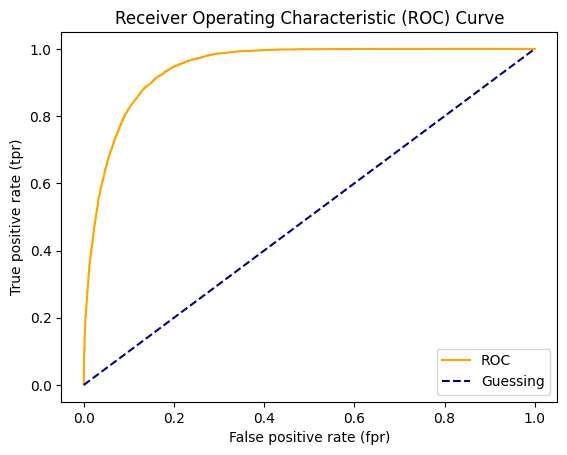


Results on TEST data:


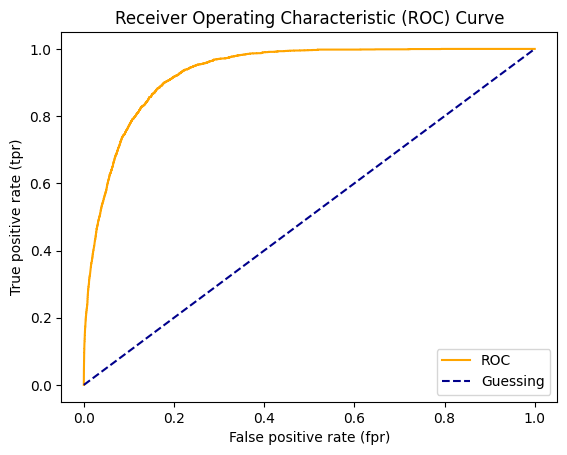

In [131]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = grid_search.best_estimator_.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = grid_search.best_estimator_.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [132]:
# Scores
print("\nResults on TRAINING data:")
gridbest_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
gridbest_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:
Accuracy            :      86.16%
Precision           :       0.73
Recall              :       0.92
F1 score            :       0.82
F1 (macro) score    :       0.85
F1 (weighted) score :       0.86
ROC-AUC             :       0.88

Results on TEST data:
Accuracy            :      83.41%
Precision           :       0.28
Recall              :       0.89
F1 score            :       0.43
F1 (macro) score    :       0.66
F1 (weighted) score :       0.87
ROC-AUC             :       0.86


# Evaluate performance of `grid_search.best_estimator_` (GridSearch run #3) vs. the `labelpartialsmote` and `baselinesmote` from before

In [133]:
# Recall:
#df_compare = pd.DataFrame({
#    'baseline_train': baseline_train_scores,
#    'baseline_test': baseline_test_scores,
#    'onehot_train': onehot_train_scores,
#    'onehot_test': onehot_test_scores,
#    'onehot_dropdayperiod_train': onehot_dropdayperiod_train_scores,
#    'onehot_dropdayperiod_test': onehot_dropdayperiod_test_scores,
#    'labelencoded_train': labelencoded_train_scores,
#    'labelencoded_test': labelencoded_test_scores,
#    'labelpartial_train': labelpartial_train_scores,
#    'labelpartial_test': labelpartial_test_scores,
#    'labelpartialsmote_train': labelpartialsmote_train_scores,
#    'labelpartialsmote_test': labelpartialsmote_test_scores})
#df_compare['baselinesmote_train'] = baselinesmote_train_scores
#df_compare['baselinesmote_test'] = baselinesmote_test_scores

# Add the GridSearch #3 best estimator scores
df_compare['gridbest_train'] = gridbest_train_scores
df_compare['gridbest_test'] = gridbest_test_scores
df_compare

,baseline_train,baseline_test,onehot_train,onehot_test,onehot_dropdayperiod_train,onehot_dropdayperiod_test,labelencoded_train,labelencoded_test,labelpartial_train,labelpartial_test,labelpartialsmote_train,labelpartialsmote_test,baselinesmote_train,baselinesmote_test,gridbest_train,gridbest_test
accuracy,0.90,0.88,0.85,0.84,0.84,0.83,0.87,0.86,0.87,0.86,0.89,0.89,0.92,0.89,0.86,0.83
precision,0.39,0.35,0.30,0.29,0.29,0.28,0.34,0.32,0.33,0.32,0.83,0.37,0.86,0.37,0.73,0.28
recall,0.98,0.85,0.94,0.88,0.93,0.88,0.95,0.89,0.94,0.90,0.86,0.79,0.91,0.78,0.92,0.89
f1,0.56,0.50,0.46,0.44,0.44,0.42,0.50,0.47,0.49,0.47,0.84,0.50,0.88,0.51,0.82,0.43
f1_macro,0.75,0.71,0.68,0.67,0.67,0.66,0.71,0.70,0.71,0.70,0.88,0.72,0.91,0.72,0.85,0.66
f1_weighted,0.92,0.90,0.88,0.88,0.88,0.87,0.90,0.89,0.89,0.89,0.89,0.91,0.92,0.91,0.86,0.87
roc_auc,0.94,0.87,0.89,0.86,0.88,0.85,0.91,0.88,0.90,0.88,0.89,0.85,0.92,0.84,0.88,0.86


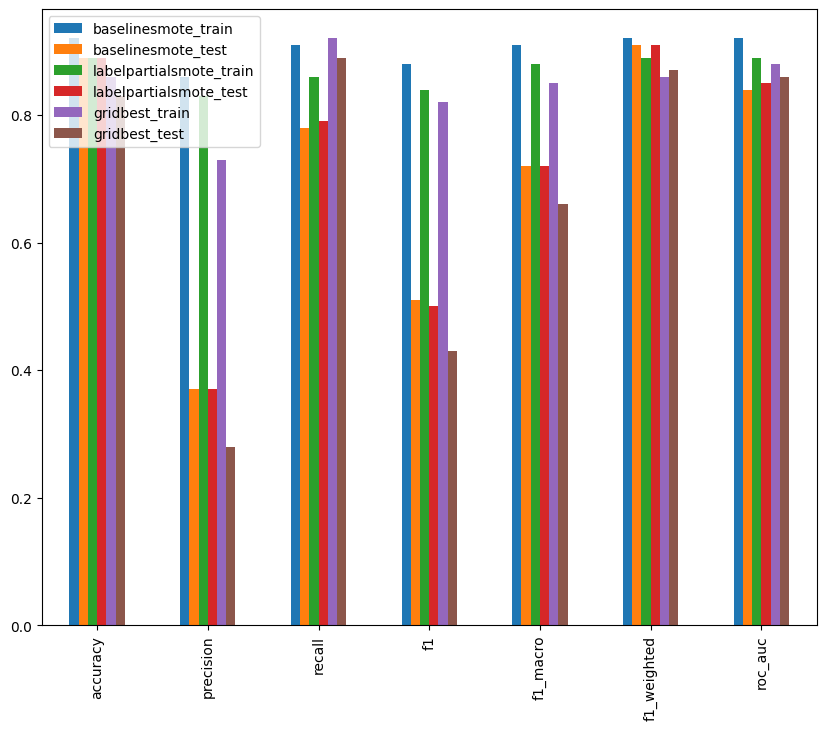

In [134]:
# Plot the scores
df_compare[['baselinesmote_train', 'baselinesmote_test', 'labelpartialsmote_train', 'labelpartialsmote_test', 'gridbest_train', 'gridbest_test']].plot.bar(figsize=(10,8));

Draw another graph comparing all scores only against the gridbest_test and labelpartialsmote_test, since those are the ones that matter most (unseen data)

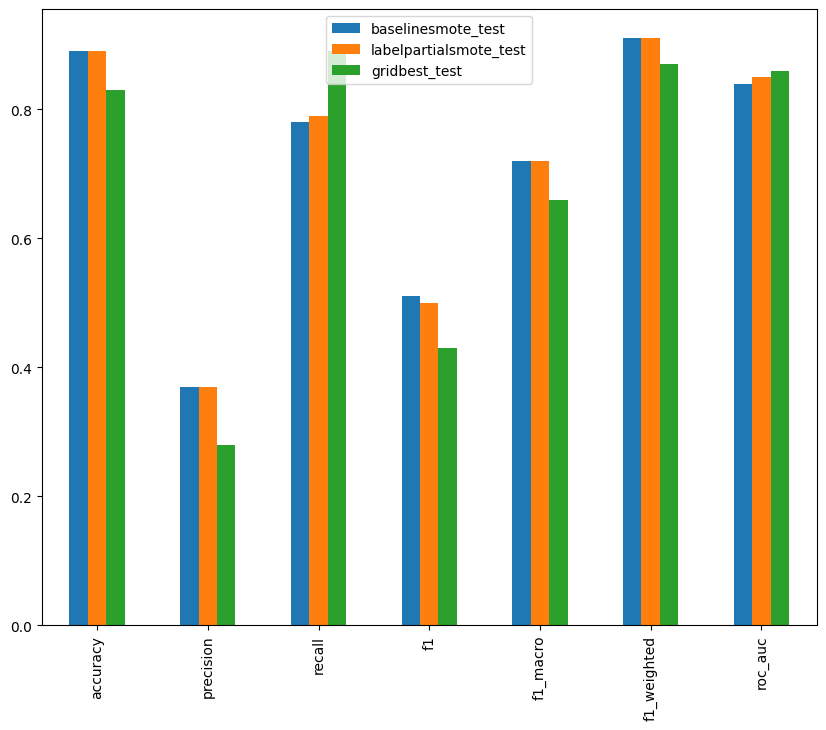

In [135]:
# Plot the scores
df_compare[['baselinesmote_test', 'labelpartialsmote_test', 'gridbest2_test', 'gridbest_test']].plot.bar(figsize=(10,8));

See the actual scores compared side by side on balanced_test vs. gridbest_test

In [136]:
df_compare[['baselinesmote_test', 'labelpartialsmote_test', 'gridbest_test']]

,baselinesmote_test,labelpartialsmote_test,gridbest_test
accuracy,0.89,0.89,0.83
precision,0.37,0.37,0.28
recall,0.78,0.79,0.89
f1,0.51,0.50,0.43
f1_macro,0.72,0.72,0.66
f1_weighted,0.91,0.91,0.87
roc_auc,0.84,0.85,0.86


TODO:  UPDATE
Findings:  The GridSearchCV's best estimator performes slightly better on F1 Macro score (0.63 vs 0.62) (worse on roc_auc with 0.71 vs. 0.74).

We will use this as the model to compare against when we go into RandomForestClassifier and XGBoostClassifier next.

But, we will save both models just in case.

# Save the Models and `grid_search` object

Save:
* `labelpartialsmote`:  The best of the XGBoostClassifier before GridSearch with SMOTE `sampling_strategy` = 0.1, Under `sampling_strategy` = 0.5
* `grid_search.best_estimator_`:  The best of the XGBoostClassifier with SMOTE `sampling_strategy` = 0.1, Under `sampling_strategy` = 0.5 and best parameters are shown in above cell
* `grid_search`:  The grid_search object for future reference, where I can read `.best_params_`, `.cv_result_`, `.best_score_` in future if needed

In [137]:
# # Setup paths and filenames

relativepath = Utility.MODELS_RELATIVE_PATH

labelpartialsmote_filename = 'labelpartialsmote_xgb.pkl'

#grid_search_filename = 'labelpartialsmote_xgb_grid_search_run3.pkl'
grid_search_filename = 'google_grid_search_obj_xgb_run3_labelpartialsmote.pkl'

#grid_search_best_estimator_filename = 'labelpartialsmote_xgb_grid_search_run3_best_estimator.pkl'
grid_search_best_estimator_filename = 'google_xgb_grid_search_run3_best_estimator_labelpartialsmote.pkl'

In [141]:
# For Google Colab
relativepath = '/content/gdrive/MyDrive/Colab Notebooks/src/'
with open(relativepath + labelpartialsmote_filename, 'wb') as f:
     pickle.dump(labelpartialsmote_xgb, f)

with open(relative path + grid_search_filename, 'wb') as f:
    pickle.dump(grid_search, f)

with open(relativepath + grid_search_best_estimator_filename, 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

In [143]:
df_compare.to_csv('/content/gdrive/MyDrive/Colab Notebooks/src/xgb_compare_model_scores.csv')